
# Day 1: Introduction

We talked today about the massive transformation that electricity markets are witnessing, with the rapid growth of renewable power and explicity goal of fully decarbonizing the electricity market in coming years.

In this practice session, we will examine time series data from the Spanish electricity market, which has substantial intermittent renewable power (wind and solar). 

The data have been collected from publicly available sources (Red Eléctrica de España and OMIE, among others). The data are from the paper "Measuring the Impact of Wind Power in the Spanish Electricity Market," by Claire Petersen, Mar Reguant, and Lola Segura.

We need to load packages in Python.

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS
from scipy.stats import binned_statistic

In [51]:
# Auxiliary function for binscatter with scipy

def binscatter_scipy(df, x, y, bins=10, ax=None, quantile_bins=True,
                     connect=True, min_count=1, **plot_kwargs):
    """
    Plot mean(y) vs mean(x) in bins of x, using scipy.stats.binned_statistic.

    - quantile_bins=True makes equal-count bins (typical binscatter).
    - connect=True draws a 'scatterpath' (points connected by a line).
    """
    d = df[[x, y]].dropna()
    xv = d[x].to_numpy()
    yv = d[y].to_numpy()

    if ax is None:
        ax = plt.gca()

    # Build bin edges
    if quantile_bins:
        if not isinstance(bins, int):
            raise ValueError("quantile_bins=True requires bins to be an int.")
        qs = np.linspace(0, 1, bins + 1)
        edges = np.unique(np.quantile(xv, qs))
        if len(edges) < 3:
            raise ValueError("Not enough unique x values to form (quantile) bins.")
        bin_edges = edges
    else:
        bin_edges = bins  # int or explicit edges

    # Compute binned means and counts
    y_mean, _, _ = binned_statistic(xv, yv, statistic="mean", bins=bin_edges)
    x_mean, _, _ = binned_statistic(xv, xv, statistic="mean", bins=bin_edges)
    counts, _, _ = binned_statistic(xv, yv, statistic="count", bins=bin_edges)

    mask = (counts >= min_count) & np.isfinite(x_mean) & np.isfinite(y_mean)
    xb = x_mean[mask]
    yb = y_mean[mask]

    # Sort by x for nice plotting
    order = np.argsort(xb)
    xb, yb = xb[order], yb[order]

    linestyle = "-" if connect else "None"
    ax.plot(xb, yb, marker="o", linestyle=linestyle, **plot_kwargs)

    return xb, yb, counts[mask]


def add_linear_fit(ax, xb, yb, **line_kwargs):
    """Fit y = a + b x on binned points and overlay the fitted line."""
    if len(xb) < 2:
        return None
    b, a = np.polyfit(xb, yb, 1)
    xs = np.linspace(xb.min(), xb.max(), 200)
    ax.plot(xs, a + b * xs, **line_kwargs)
    return a, b

We load the data using the CSV syntax (`CSV.read`) into a data frame called `df`. `first(df,5)` gives us a snapshot of the data. Make sure the data is in the same directory as the notebook or specify the full path name.

In [52]:
df = pd.read_csv("data_spain.csv")   # adjust path if needed
df.head()

,year,month,day,hour,dayofweek,demand,demand_forecast,wind,wind_forecast,wholesale_price,system_costs,emis_tCO2
0,2009,5,1,1,5,25.337,25.021000,5.7625,5.427,40.00,0.42,4479.166667
1,2009,5,1,2,5,23.478,23.044001,5.7461,5.441,40.20,0.24,3826.000000
2,2009,5,1,3,5,21.859,21.684999,5.7860,5.487,40.00,0.84,3359.666667
3,2009,5,1,4,5,20.931,20.408001,5.9837,5.532,36.39,2.27,3199.833333
4,2009,5,1,5,5,20.371,19.586000,6.0831,5.551,33.32,4.35,3418.333333


## Summary Statistics

We start by displaying some statistics and plot hourly and yearly patterns of wind production and electricity demand.

Variables in Julia are defined by colons (:). eltype determines the type of the variable. Note that Julia differentiates between Integers (1) and Floating-Point (1.0)


In [53]:
df.describe(include="all")

,year,month,day,hour,dayofweek,demand,demand_forecast,wind,wind_forecast,wholesale_price,system_costs,emis_tCO2
count,78731.000000,78731.000000,78731.000000,78731.000000,78731.000000,78707.000000,78731.000000,78731.000000,78730.000000,78731.000000,78731.000000,78730.000000
mean,2013.388576,6.543877,15.710914,12.486492,3.003340,28.655597,28.689824,5.383975,5.293887,44.832231,3.968258,7087.110883
std,2.650560,3.412749,8.818906,6.921099,2.000191,4.844160,4.888545,3.090204,2.958359,15.493668,3.173747,2771.432907
min,2009.000000,1.000000,1.000000,1.000000,0.000000,17.096000,14.380000,0.155200,0.398000,0.000000,-1.810000,0.000000
25%,2011.000000,4.000000,8.000000,6.000000,1.000000,24.505000,24.511000,2.958600,2.969000,36.880000,1.960000,4823.500000
50%,2013.000000,7.000000,16.000000,12.000000,3.000000,28.827000,28.853001,4.789900,4.698000,46.500000,3.220000,7204.516221
75%,2016.000000,10.000000,23.000000,18.000000,5.000000,32.341500,32.421001,7.250400,7.064000,54.300000,5.070000,9222.637960
max,2018.000000,12.000000,31.000000,24.000000,6.000000,43.588000,43.568001,17.496300,16.768000,145.000000,99.389999,15772.666667


In order to plot hourly and yearly patterns, we first need to combine the data at those levels. For that, we first define the groups for which the functions will be applied using `groupby`. `agg` is then used to compute the specified summary statistic. Finally, we rename the variable as `wind_mean`.

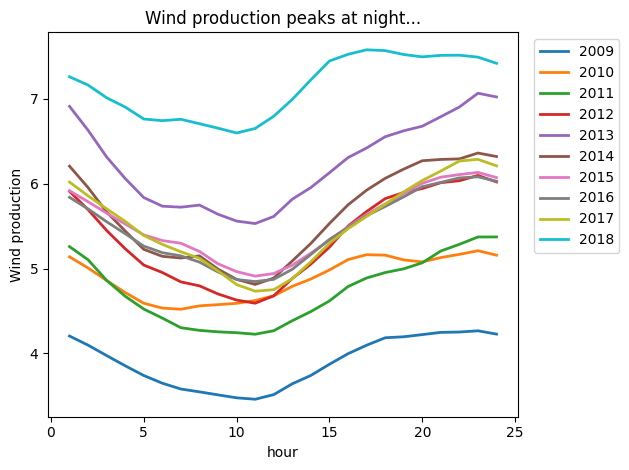

In [54]:
# --- Hourly patterns by year (combine + plot with group=year) ---
df_mean = (
    df.groupby(["hour", "year"], as_index=False)
      .agg(wind_mean=("wind", "mean"),
           demand_mean=("demand", "mean"))
)

# Wind by hour, separate line for each year
plt.figure()
for yr, g in df_mean.groupby("year"):
    plt.plot(g["hour"], g["wind_mean"], linewidth=2, label=str(yr))
plt.title("Wind production peaks at night...")
plt.xlabel("hour")
plt.ylabel("Wind production")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

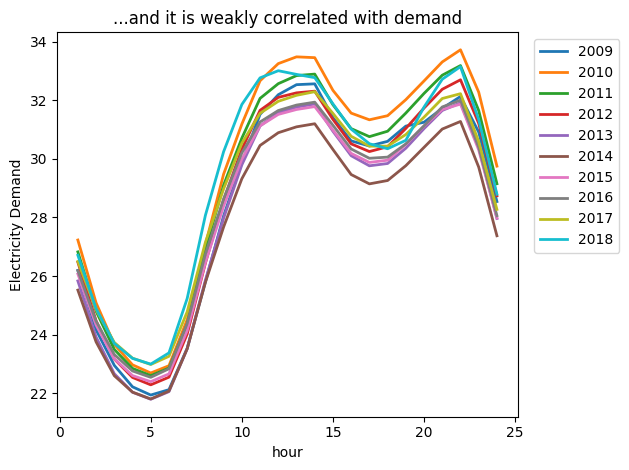

In [55]:
# Demand by hour, separate line for each year
plt.figure()
for yr, g in df_mean.groupby("year"):
    plt.plot(g["hour"], g["demand_mean"], linewidth=2, label=str(yr))
plt.title("...and it is weakly correlated with demand")
plt.xlabel("hour")
plt.ylabel("Electricity Demand")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

## The impacts of wind: a visual exploration

We will be plotting the **impacts of wind** on several outcomes of interest:
* Emissions
* Wholesale prices
* System costs
* Wholesale prices + system costs

We will be using bin scatters for plotting.

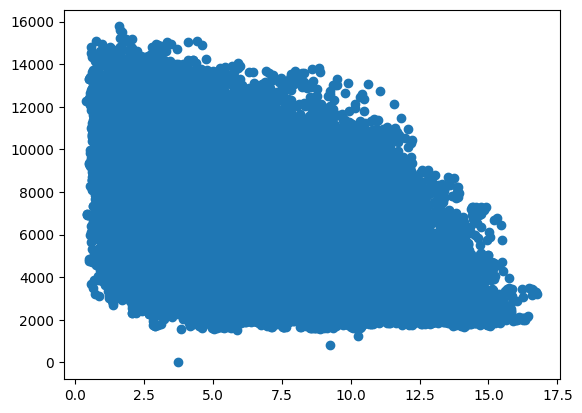

In [56]:
# This is impossible to parse!
plt.scatter(df.wind_forecast, df.emis_tCO2)
plt.show()

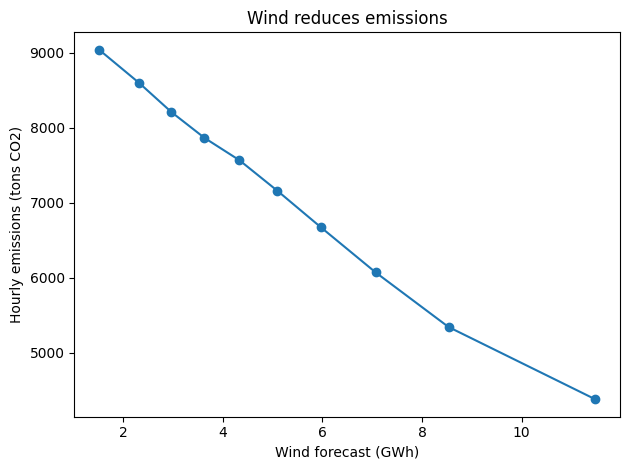

In [57]:
# Example: wind_forecast vs emissions
fig, ax = plt.subplots()
out = binscatter_scipy(df, x="wind_forecast", y="emis_tCO2", bins=10, ax=ax, connect=True)
ax.set_title("Wind reduces emissions")
ax.set_xlabel("Wind forecast (GWh)")
ax.set_ylabel("Hourly emissions (tons CO2)")
plt.tight_layout()
plt.show()

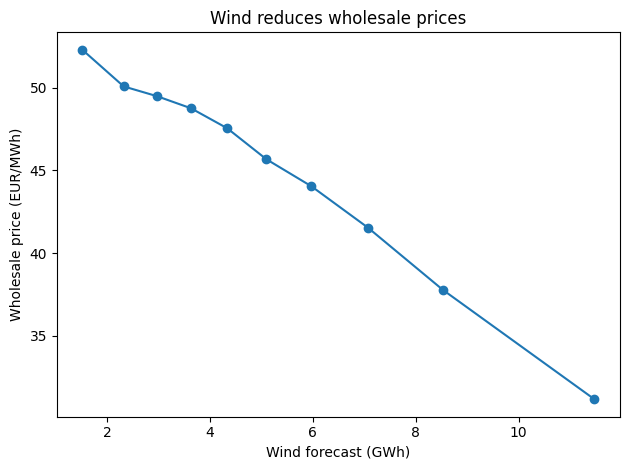

In [58]:
# Wind reduces wholesale prices
fig, ax = plt.subplots()
binscatter_scipy(df, x="wind_forecast", y="wholesale_price", bins=10, ax=ax, connect=True)
ax.set_title("Wind reduces wholesale prices")
ax.set_xlabel("Wind forecast (GWh)")
ax.set_ylabel("Wholesale price (EUR/MWh)")
plt.tight_layout()
plt.show()


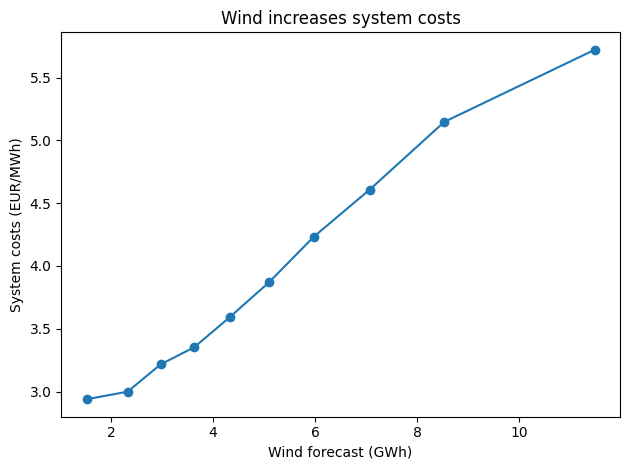

In [59]:
# Wind increases system costs
fig, ax = plt.subplots()
binscatter_scipy(df, x="wind_forecast", y="system_costs", bins=10, ax=ax, connect=True)
ax.set_title("Wind increases system costs")
ax.set_xlabel("Wind forecast (GWh)")
ax.set_ylabel("System costs (EUR/MWh)")
plt.tight_layout()
plt.show()

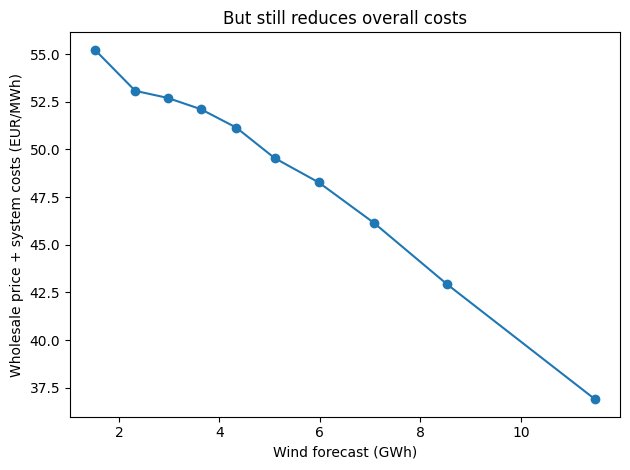

In [60]:
# But still reduces overall costs (define total_price first)
df["total_price"] = df["wholesale_price"] + df["system_costs"]

fig, ax = plt.subplots()
binscatter_scipy(df, x="wind_forecast", y="total_price", bins=10, ax=ax, connect=True)
ax.set_title("But still reduces overall costs")
ax.set_xlabel("Wind forecast (GWh)")
ax.set_ylabel("Wholesale price + system costs (EUR/MWh)")
plt.tight_layout()
plt.show()

## Wind endogeneity

One can estimate the effects of wind using a regression framework. However, it is important to keep in mind that wind production can be endogenous.

In moments of very high forecasted wind, it is often the case that wind is discarded. This can create an endogeneity problem.

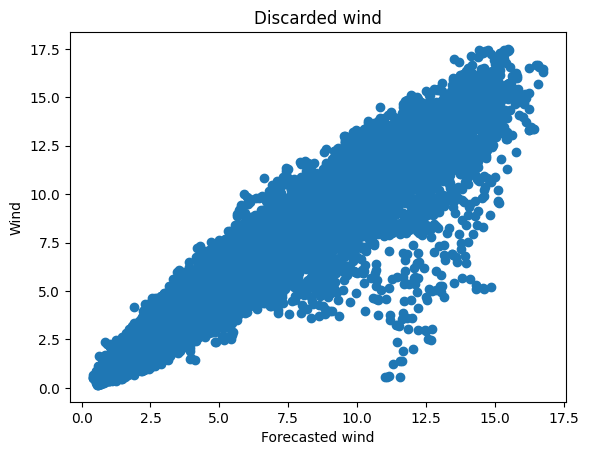

In [61]:
plt.scatter(df.wind_forecast, df.wind)
plt.xlabel("Forecasted wind")
plt.ylabel("Wind")
plt.title("Discarded wind")
plt.show()

We can examine the endogeneity problem in the context of assessing the impact of wind on reliability and other congestion costs ("system costs").

On days of very high wind, measured wind production could be lower than expected, leading to a downward bias in our estimates: a difficult day with lots of wind appears as a day with low levels of wind in the data.

To address this issue, one can use forecasted wind as an exogenous variable.

We will be running these regressions using the stats models library.

In [70]:
reg_w  = smf.ols("system_costs ~ wind + C(year) + C(month)", data=df).fit()
print(reg_w.summary())

                            OLS Regression Results                            
Dep. Variable:           system_costs   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     1105.
Date:                Wed, 07 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:16:15   Log-Likelihood:            -1.9247e+05
No. Observations:               78731   AIC:                         3.850e+05
Df Residuals:                   78709   BIC:                         3.852e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.0593      0.057     

In [71]:
reg_wf = smf.ols("system_costs ~ wind_forecast + C(year) + C(month)", data=df).fit()
print(reg_wf.summary())

                            OLS Regression Results                            
Dep. Variable:           system_costs   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     1153.
Date:                Wed, 07 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:16:27   Log-Likelihood:            -1.9208e+05
No. Observations:               78730   AIC:                         3.842e+05
Df Residuals:                   78708   BIC:                         3.844e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.8607      0.057     

We might want to instrument wind production with its forecast instead using linearmodels.

In [64]:
d = df[["system_costs","wind","wind_forecast","year","month"]].dropna()

# 1st stage: wind on instrument + FE
fs = smf.ols("wind ~ wind_forecast + C(year) + C(month)", data=d).fit()
d = d.assign(wind_hat=fs.fittedvalues)

# 2nd stage: outcome on predicted wind + FE
ss = smf.ols("system_costs ~ wind_hat + C(year) + C(month)", data=d).fit()

print(ss.summary())


# Alternative: use linearmodels IV2SLS
# iv = IV2SLS.from_formula("system_costs ~ 1 + C(year) + C(month) + [wind ~ wind_forecast]", data=d).fit(cov_type="robust")   # or "unadjusted", "robust", "clustered"
# print(iv.summary)

                            OLS Regression Results                            
Dep. Variable:           system_costs   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     1153.
Date:                Wed, 07 Jan 2026   Prob (F-statistic):               0.00
Time:                        09:39:06   Log-Likelihood:            -1.9208e+05
No. Observations:               78730   AIC:                         3.842e+05
Df Residuals:                   78708   BIC:                         3.844e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.8803      0.057     

Another possible problem is that system costs from wind production may be realized in hours with no wind. In this case, the hourly regression coefficient will be downward biased. To circumvent this issue, we can estimate the same regression at a daily level.

For that, we compute the total system costs as well as total wind power.

In [65]:
df["day_id"] = df["year"].astype(str) + df["month"].astype(str) + df["day"].astype(str)

df_day = df.groupby(["day_id", "year", "month"], as_index=False).agg(wind_forecast=("wind_forecast", "sum"), systemcosts=("system_costs", "sum"))

In [72]:
reg_d = smf.ols("systemcosts ~ wind_forecast + C(year) + C(month)", data=df_day).fit()
print(reg_d.summary())

                            OLS Regression Results                            
Dep. Variable:            systemcosts   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     160.5
Date:                Wed, 07 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:16:37   Log-Likelihood:                -16508.
No. Observations:                3294   AIC:                         3.306e+04
Df Residuals:                    3272   BIC:                         3.319e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          39.7021      3.682     

We can display the output of our regressions.

In [67]:
tbl = summary_col(
    results=[reg_w, reg_wf, reg_d],
    model_names=["Hourly: wind", "Hourly: wind_forecast", "Daily: wind_forecast"],
    stars=True,
    info_dict={
        "N": lambda x: f"{int(x.nobs)}",
        "Adj. R2": lambda x: f"{x.rsquared_adj:.4f}",
    }
)
print(tbl)


                Hourly: wind Hourly: wind_forecast Daily: wind_forecast
-----------------------------------------------------------------------
Intercept       2.0593***    1.8607***             39.7021***          
                (0.0567)     (0.0568)              (3.6822)            
C(year)[T.2010] 0.6876***    0.7202***             17.1818***          
                (0.0480)     (0.0478)              (3.0692)            
C(year)[T.2011] 0.3594***    0.3924***             9.4415***           
                (0.0477)     (0.0475)              (3.0467)            
C(year)[T.2012] 1.8192***    1.8063***             42.6135***          
                (0.0478)     (0.0475)              (3.0524)            
C(year)[T.2013] 2.5999***    2.4847***             58.0648***          
                (0.0482)     (0.0481)              (3.0961)            
C(year)[T.2014] 2.8978***    2.8245***             65.7179***          
                (0.0480)     (0.0479)              (3.0714)    

## Follow-up exercises

1. What is the correlation of wind and demand? How could that affect the valuation of wind power?

2. (*) What is the environmental benefit of wind power in this market per unit of wind? Try to quantify that by regressing emissions on wind and converting it to a monetary amount using a valuation for emissions reductions. 
Estimate the total welfare effects of wind production. For that, you need to add to the environmental benefit the consumer and producer surplus. With respect to the producer surplus assume that the LCOE ranges between 50 to 90 €/MWh. How does your answer depend on the monetary value of reducing emissions?